In [1]:
from sisl import *
import numpy as np
from sisl.io import *
import sisl.viz
# from sisl.viz import merge_plots
import matplotlib.pyplot as plt
from time import time
from scipy import linalg
import os
import h5py

%matplotlib inline

In [4]:
import json
import argparse
import h5py
import numpy as np
import os
from time import time
from scipy.sparse import csc_matrix 
from scipy.linalg import eigh, qr
from scipy.sparse.linalg import eigs
from sisl import *

input_dir = "/fs2/home/ndsim10/graphene_example/work_dir/inference/graphene450/"

def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(','))) ##假设键的格式类似于"[0,0,0,2,3]"，key[1:-1]即不读取开头和结尾的括号，然后根据逗号分隔键的内容并转换为整数元组。
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out


ev2Hartree = 0.036749324533634074
Bohr2Ang = 0.529177249


def genlist(x):
    return np.linspace(x[0], x[1], int(x[2]), endpoint=False)


def k_data2num_ks(kdata):
    return int(kdata.split()[0])


def k_data2kpath(kdata):
    return [float(x) for x in kdata.split()[1:7]]


def std_out_array(a):
    return ''.join([str(x) + ' ' for x in a])

def std_out_EKarray(E_K):
    output = ""  # 初始化一个空字符串，用于累加每行的字符串表示
    for ek in E_K:
        line = ''.join(str(x)+" " for x in ek) + "\n"  # 将一行转换为字符串并加上换行符
        output += line  # 将这一行添加到输出字符串中
    return output

def str_to_bool(s):
    return s == "True"

def constructmeshkpts(nkmesh, offset=[0.0, 0.0, 0.0], k1=[0.0, 0.0, 0.0], k2=[1.0, 1.0, 1.0]):
    if len(nkmesh) != 3:
        raise ValueError("nkmesh must be of size 3.")
    nkpts = np.prod(nkmesh)
    kpts = np.zeros((3, nkpts))
    ik = 0
    for ikx in range(nkmesh[0]):
        for iky in range(nkmesh[1]):
            for ikz in range(nkmesh[2]):
                kpts[:, ik] = [
                    (ikx / nkmesh[0]) * (k2[0] - k1[0]) + k1[0],
                    (iky / nkmesh[1]) * (k2[1] - k1[1]) + k1[1],
                    (ikz / nkmesh[2]) * (k2[2] - k1[2]) + k1[2]
                ]
                ik += 1
    return kpts + np.array(offset).reshape(3, 1)


default_dtype = np.complex128 #设置了 NumPy 数组的默认数据类型为复数类型 complex128。在 NumPy 中，数据类型 np.complex128 表示复数，由双精度浮点数构成，即实部和虚部都是双精度浮点数。

calc_bands = True
calc_dos = True

if os.path.isfile(os.path.join(input_dir, "info.json")):
    with open(os.path.join(input_dir, "info.json")) as f:
        spinful = json.load(f)["isspinful"] #False
else:
    spinful = False

site_positions = np.loadtxt(os.path.join(input_dir, "site_positions.dat")) #(3,244)原子坐标

if len(site_positions.shape) == 2:
    nsites = site_positions.shape[1] #244
else:
    nsites = 1
    # in case of single atom

# require transposition while reading rlat.dat in python
rlat = np.loadtxt(os.path.join(input_dir, "rlat.dat")).T #读取倒格矢(3,3)

site_norbits = np.loadtxt(os.path.join(input_dir, 'num_orbital_per_atom.dat')).astype(int) #[244个9]
norbits = np.sum(site_norbits) #244*9=2196
site_norbits_cumsum = np.cumsum(site_norbits) #site_norbits_cumsum:[9   18   27 ... 2196]
# print(site_norbits)
# print(norbits)
# print(site_norbits_cumsum)



print("read h5")
begin_time = time()
hamiltonians_pred = _create_dict_h5(os.path.join(input_dir, "hamiltonians_pred.h5")) #读取预测的哈密顿量矩阵
overlaps = _create_dict_h5(os.path.join(input_dir, "overlaps.h5")) #读取siesta_get_data预先计算的重叠矩阵
print("Time for reading h5: ", time() - begin_time, "s")


H_R = {}
S_R = {}

print("construct Hamiltonian and overlap matrix in the real space")
begin_time = time()

# BS:
# this is for debug python and julia
# in julia, you can use 'sort(collect(keys(hamiltonians_pred)))'
# for key in dict(sorted(hamiltonians_pred.items())).keys():
for key in hamiltonians_pred.keys():

    hamiltonian_pred = hamiltonians_pred[key] #读取预测的每一个key的哈密顿量矩阵

    if key in overlaps.keys(): #预测哈密顿量矩阵的key，在重叠矩阵的key中，则读取对应key的重叠矩阵，否则生成一个类哈密顿量矩阵的0矩阵
        overlap = overlaps[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
    if spinful: #如果存在自旋，构建自旋的重叠矩阵
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3] #读取key中的R，即原子所属的晶胞的索引
    atom_i = key[3] - 1 #读取在晶胞R中存在连接的原子i和原子j
    atom_j = key[4] - 1

    assert (site_norbits[atom_i], site_norbits[atom_j]) == hamiltonian_pred.shape #(9,9)的矩阵
    assert (site_norbits[atom_i], site_norbits[atom_j]) == overlap.shape #(9,9)的矩阵

    if R not in H_R.keys(): #True
        H_R[R] = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)

    for block_matrix_i in range(1, site_norbits[atom_i]+1): #1-9
        for block_matrix_j in range(1, site_norbits[atom_j]+1): #1-9
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1 #key中R对应的是轨道所属的晶胞索引，这里是求得原子i所在晶胞内的实际原子轨道
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1] #将两个原子的轨道对的预测的的哈密顿量值填充到H_R[R]中，H_R[R]是（244*9=2196）*（244*9=2196）
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1] #将两个原子对的重叠矩阵值填充到S_R[R]中
#到这里就得到了实空间的哈密顿矩阵H_R和重叠矩阵S_R

print("Time for constructing Hamiltonian and overlap matrix in the real space: ", time() - begin_time, " s")

read h5


/tmp/ipykernel_1040226/1207844141.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data = np.array(fid[key])


Time for reading h5:  5.691391944885254 s
construct Hamiltonian and overlap matrix in the real space
Time for constructing Hamiltonian and overlap matrix in the real space:  4.864829063415527  s


In [5]:
geom = sisl.get_sile("/fs2/home/ndsim10/graphene_example/work_dir/olp/graphene450/input.fdf").read_geometry()
hsx = hsxSileSiesta("/fs2/home/ndsim10/graphene_example/work_dir/olp/graphene450/graphene450.HSX")
print(geom)
print(type(hsx))
H = hsx.read_hamiltonian(geometry=geom)
S = hsx.read_overlap(geometry=geom) #这个方式是单独读取出重叠矩阵，与H.S的值相同。

Geometry{na: 450, no: 5850,
 Atoms{species: 1,
  Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.54640,
   AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1216000000000035, q0: 2.0}},
   AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6771999999999991, q0: 0.0}},
   AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
   AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
   AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
   AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
   AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
   AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
   AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.546400000000014, q0: 0.0}},
   AtomicOrbital{3dyzZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.546400000000014, q0: 0.0

In [6]:
print(H.shape)
print(S.shape)

(5850, 52650, 2)
(5850, 52650, 1)


In [19]:
H_tmp = H.tocsr().toarray()
print(H_tmp.shape)

(5850, 52650)


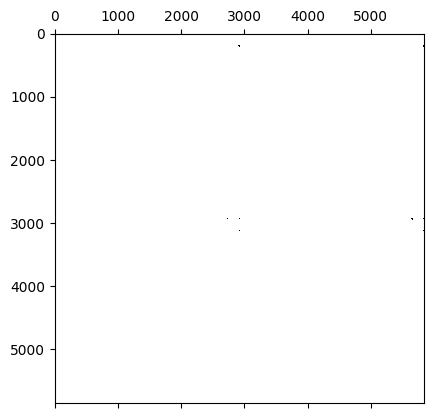

In [63]:
plt.spy(H_tmp[:,5850*8:5850*9])#(0,0,0),(-1,-1,0),(0,-1,0),(1,-1,0),(-1,0,0),(1,0,0),(-1,1,0),(0,1,0),(1,1,0)

(5850, 5850)


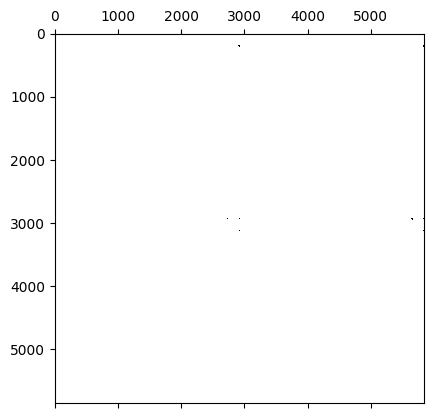

In [62]:
tmp = np.array(list(H_R.values())[8]).real
print(tmp.shape)
plt.spy(tmp)

In [126]:
H_empty = Hamiltonian(geom, orthogonal=False)
print(H_empty.shape)

(5850, 52650, 2)


In [127]:
print(H_empty[0,0])

[0. 0.]


In [139]:
print(H_empty.nnz)
print(H.nnz)
print(S.nnz)
num_orb = H.no
print(num_orb)

0
2770650
2770650
5850


In [140]:
H_R[(-1, -1, 0)]

array([[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       ...,
       [ 1.49415487+0.j,  1.38581716+0.j,  0.43434814+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.81713489+0.j,  0.85048487+0.j,  0.52456832+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.08846649+0.j,  0.32902517+0.j, -0.25471664+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j]])

In [150]:
R_list = list(H_R.keys())
print(R_list)

[(-1, -1, 0), (-1, 0, 0), (-1, 1, 0), (0, -1, 0), (0, 0, 0), (0, 1, 0), (1, -1, 0), (1, 0, 0), (1, 1, 0)]


In [155]:
S.shape

(5850, 52650, 1)

In [156]:
for i, j in S.iter_nnz():
    H_empty.S[i, j] = S[i, j]

In [161]:
for i, j in S.iter_nnz():
    if j>=0 and j<num_orb:
        key = (0, 0, 0)
    elif j>=num_orb*1 and j<num_orb*2:
        key = (-1, -1, 0)
    elif j>=num_orb*2 and j<num_orb*3:
        key = (0, -1, 0)
    elif j>=num_orb*3 and j<num_orb*4:
        key = (1, -1, 0)
    elif j>=num_orb*4 and j<num_orb*5:
        key = (-1, 0, 0)
    elif j>=num_orb*5 and j<num_orb*6:
        key = (1, 0, 0)
    elif j>=num_orb*6 and j<num_orb*7:
        key = (-1, 1, 0)
    elif j>=num_orb*7 and j<num_orb*8:
        key = (0, 1, 0)
    elif j>=num_orb*8 and j<num_orb*9:
        key = (1, 1, 0)
    else:
        raise ValueError('Exceeds the maximum orbital index')
    H_empty.H[i, j] = H_R[key].real[i, j%num_orb]

In [119]:
#这个方法太慢！弃用！
#my_dict = {"(-1, -1, 0)":1, "(-1, 0, 0)":4, "(-1, 1, 0)":6, "(0, -1, 0)":2, "(0, 0, 0)":0,  "(0, 1, 0)":7, "(1, -1, 0)":3, "(1, 0, 0)":5, "(1, 1, 0)":8}
#(0,0,0),(-1,-1,0),(0,-1,0),(1,-1,0),(-1,0,0),(1,0,0),(-1,1,0),(0,1,0),(1,1,0)
# for key in H_R.keys():
#     print(key)
#     idx = my_dict[str(key)]
#     tmp = H_R[key].real
#     # print(tmp)
#     for i in range(tmp.shape[0]):
#         for j in range(tmp.shape[1]):
#             H_empty.H[i, 5850*idx+j] = tmp[i,j]

In [168]:
H_empty.nnz

2770650

In [169]:
H.nnz

2770650

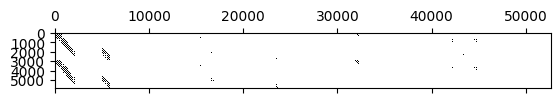

In [171]:
H_0 = H_empty.tocsr().toarray()
plt.spy(H_0)

/tmp/ipykernel_1040226/4051495067.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


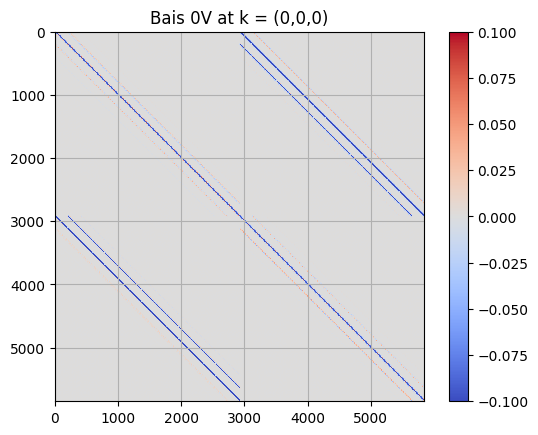

In [172]:
#哈密顿矩阵误差对比图
H_0_0 = H_0[:,:5850]
min_value = np.min(H_0_0)
max_value = np.max(H_0_0)
cmap = plt.cm.get_cmap('coolwarm')
# plt.imshow(H_0_0, cmap=cmap, vmin=min_value, vmax=max_value)
plt.imshow(H_0_0, cmap=cmap, vmin=-0.1, vmax=0.1)
# plt.imshow(Sk, cmap=cmap)
plt.colorbar()
plt.grid()
plt.title("Bais 0V at k = (0,0,0)")
plt.show()

/tmp/ipykernel_1040226/3355671493.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


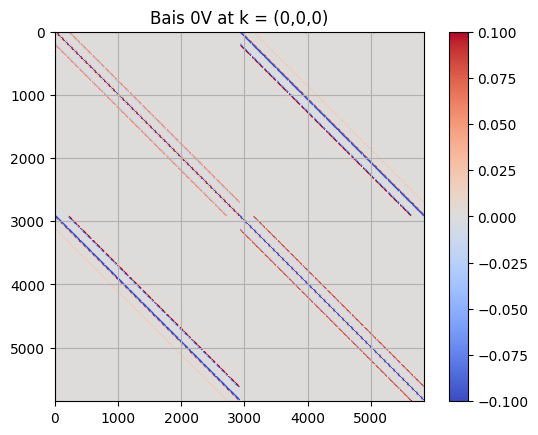

In [173]:
#哈密顿矩阵误差对比图
H_t = H.tocsr().toarray()[:, :5850]
min_value = np.min(H_t)
max_value = np.max(H_t)
cmap = plt.cm.get_cmap('coolwarm')
# plt.imshow(H_0_0, cmap=cmap, vmin=min_value, vmax=max_value)
plt.imshow(H_t, cmap=cmap, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.grid()
plt.title("Bais 0V at k = (0,0,0)")
plt.show()

#### 单步计算的重叠矩阵和完全自洽收敛的重叠矩阵是否相同

In [196]:
def ratate_H(H_pred):
    indexc = [0,1,3,4,2,6,7,5,10,12,8,11,9]
    index = []
    for i in range(800): #800个原子
        for j in indexc:
            r = i * 13
            c = r + j
            index.append(c)

    l = [0,0,1,1,1,1,1,1,2,2,2,2,2]

    H_tmp1 = np.zeros_like(H_pred)
    j=0
    for i in index:
        H_tmp1[j] = H_pred[i] * ((-1)**(l[i%13]))
        j=j+1

    H_tmp2 = np.zeros_like(H_pred)
    j=0
    for i in index:
        H_tmp2[:,j] = H_tmp1[:,i] * ((-1)**(l[i%13]))
        j=j+1
    return H_tmp2
for key in [(-1, -1, 0), (-1, 0, 0), (-1, 1, 0), (0, -1, 0), (0, 0, 0), (0, 1, 0), (1, -1, 0), (1, 0, 0), (1, 1, 0)]:
    print(key)
    H_R[key] = ratate_H(H_R[key])

(-1, -1, 0)
(-1, 0, 0)
(-1, 1, 0)
(0, -1, 0)
(0, 0, 0)
(0, 1, 0)
(1, -1, 0)
(1, 0, 0)
(1, 1, 0)


In [197]:
print(H.H.shape)
t = 0
for i in range(0,100):
    print("real_H_{}_{} = {}".format(t,i,H.H[t,i]))
print("====================================================")
print(H_R.keys())
print(H_R[(0, 0, 0)].shape)
#由于预测的哈密顿量轨道和sisl包中的轨道排序不同，因此预测出的哈密顿量矩阵不sisl包读取的哈密顿量矩阵不同，但重叠矩阵相同，因此不用交换轨道
for i in range(100):
    print("pred_H_{}_{} = {}".format(t,i,H_R[(0, 0, 0)][t,i].real))

(10400, 93600, 2)
real_H_0_0 = -16.709482192993164
real_H_0_1 = -15.225933074951172
real_H_0_2 = 0.00013050492270849645
real_H_0_3 = 6.16948983220289e-12
real_H_0_4 = 0.0002968747285194695
real_H_0_5 = 0.00012546346988528967
real_H_0_6 = 1.0113214925873068e-13
real_H_0_7 = 0.0003244242398068309
real_H_0_8 = -1.8864438970922492e-05
real_H_0_9 = 3.7761880753404975e-15
real_H_0_10 = 3.989349842071533
real_H_0_11 = -2.353242688874716e-14
real_H_0_12 = -6.64554609102197e-05
real_H_0_13 = 0.0
real_H_0_14 = 0.0
real_H_0_15 = 0.0
real_H_0_16 = 0.0
real_H_0_17 = 0.0
real_H_0_18 = 0.0
real_H_0_19 = 0.0
real_H_0_20 = 0.0
real_H_0_21 = 0.0
real_H_0_22 = 0.0
real_H_0_23 = 0.0
real_H_0_24 = 0.0
real_H_0_25 = 0.0
real_H_0_26 = 0.0
real_H_0_27 = 0.0
real_H_0_28 = 0.0
real_H_0_29 = 0.0
real_H_0_30 = 0.0
real_H_0_31 = 0.0
real_H_0_32 = 0.0
real_H_0_33 = 0.0
real_H_0_34 = 0.0
real_H_0_35 = 0.0
real_H_0_36 = 0.0
real_H_0_37 = 0.0
real_H_0_38 = 0.0
real_H_0_39 = 0.0
real_H_0_40 = 0.0
real_H_0_41 = 0.0
real

In [198]:
index = H.H.nonzero()
print(index[0].shape)
print(index[1].shape)
index = H.S.nonzero()
print(index[0].shape)
print(index[1].shape)

(4925600,)
(4925600,)
(4925600,)
(4925600,)


In [199]:
index = np.nonzero(H.S)
print(index[0])
print(index[1])

[    0     0     0 ... 10399 10399 10399]
[    0     1     2 ... 88982 88983 88984]


In [200]:
index = H_empty.H.nonzero()
print(index[0].shape)
print(index[1].shape)

(0,)
(0,)


In [201]:
index = H_empty.S.nonzero()
print(index[0].shape)
print(index[1].shape)

(0,)
(0,)


In [202]:
S_nonzero_indices = H.S.nonzero()
for i in range(S_nonzero_indices[0].shape[0]):
    H_empty.S[S_nonzero_indices[0][i], S_nonzero_indices[1][i]] = H.S[S_nonzero_indices[0][i], S_nonzero_indices[1][i]]

In [203]:
index = H_empty.S.nonzero()
print(index[0].shape)
print(index[1].shape)

(4925600,)
(4925600,)


In [204]:
nonzero_index = np.nonzero(H_R[(0,0,0)])
print(nonzero_index[0])
print(nonzero_index[0].shape)
print(nonzero_index[1])
print(nonzero_index[1].shape)
print(nonzero_index[0].shape[0])

[    0     0     0 ... 10399 10399 10399]
(4476134,)
[    0     1     2 ... 10397 10398 10399]
(4476134,)
4476134


In [205]:
#方法一：把H_R中真正的非零元素都复制到H_pred中，这种方法得到的态密度很好，能带一塌糊涂
n = H_empty.shape[0]
for key in H_R.keys():
    print(key)
    if key == (-1, -1, 0):
        no = 8 * n
    elif key == (-1, 0, 0):
        no = 4 * n
    elif key == (-1, 1, 0):
        no = 6 * n
    elif key == (0, -1, 0):
        no = 2 * n
    elif key == (0, 0, 0):
        no = 0 * n
    elif key == (0, 1, 0):
        no = 7 * n
    elif key == (1, -1, 0):
        no = 3 * n
    elif key == (1, 0, 0):
        no = 5 * n
    elif key == (1, 1, 0):
        no = 1 * n
    nonzero_index = np.nonzero(H_R[key].real)
    for i in range(nonzero_index[0].shape[0]):
        H_empty.H[nonzero_index[0][i], nonzero_index[1][i]+no] = H_R[key][nonzero_index[0][i], nonzero_index[1][i]].real

(-1, -1, 0)
(-1, 0, 0)
(-1, 1, 0)
(0, -1, 0)
(0, 0, 0)
(0, 1, 0)
(1, -1, 0)
(1, 0, 0)
(1, 1, 0)


In [60]:
#方法二：把H_pred.S的非零元素位置找出来，然后把这些位置的数在H_R[key]中找出来，复制给H_pred.H。这种方法能带一般，态密度还行
for i, j in H_pred.S.iter_nnz():
    n = j // 5850
    m = j % 5850
    if n == 8:
        key = (-1, -1, 0)
    elif n == 4:
        key = (-1, 0, 0)
    elif n == 6:
        key = (-1, 1, 0)
    elif n == 2:
        key = (0, -1, 0)
    elif n == 0:
        key = (0, 0, 0)
    elif n == 7:
        key = (0, 1, 0)
    elif n == 3:
        key = (1, -1, 0)
    elif n == 5:
        key = (1, 0, 0)
    elif n == 1:
        key = (1, 1, 0)
    else:
        print("出现不在索引范围内的数据")
        break
#     print(i,j,H_R[key][i,m].real)
    H_pred.H[i,j] = np.float32(H_R[key][i,m].real)

In [206]:
print(H.H.nnz)
print(H_empty.H.nnz)
print(H.S.nnz)
print(H_empty.S.nnz)

4925600
5015230
4925600
5015230


In [174]:
print(H)
print(H_empty)

Hamiltonian{non-zero: 2770650, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 450, no: 5850,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.54640,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1216000000000035, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.6771999999999991, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.527400000000016, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7504, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.546400000000014, q0: 0.0}

In [175]:
print(H.Hk())
print(H_empty.Hk())

  (0, 0)	-16.70934295654297
  (0, 1)	-15.225773811340332
  (0, 2)	0.00019299061386846006
  (0, 3)	6.150584382080826e-12
  (0, 4)	-3.8473524909932166e-05
  (0, 5)	0.000219356021261774
  (0, 6)	8.882553302917359e-14
  (0, 7)	-4.838259701500647e-05
  (0, 8)	4.429894397617318e-05
  (0, 9)	1.4871108639015495e-16
  (0, 10)	3.9894070625305176
  (0, 11)	3.5497112646398397e-16
  (0, 12)	-0.0003749020688701421
  (0, 13)	-1.5822250843048096
  (0, 14)	-0.9402943849563599
  (0, 15)	2.5418291091918945
  (0, 16)	6.883870643653589e-13
  (0, 17)	-1.6388729810714722
  (0, 18)	1.1333599090576172
  (0, 19)	2.0663211538953646e-13
  (0, 20)	-0.7017005681991577
  (0, 21)	2.9604902267456055
  (0, 22)	-1.678889015657714e-12
  (0, 23)	1.9260894060134888
  (0, 24)	1.0186965203676235e-12
  :	:
  (5849, 5825)	1.704025387763977
  (5849, 5826)	0.857489824295044
  (5849, 5827)	-8.219670603881735e-13
  (5849, 5828)	-2.733457565307617
  (5849, 5829)	0.8651480674743652
  (5849, 5830)	-3.5129985400707275e-13
  (5849, 583

### siesta计算和预测的费米能级对比

In [176]:
#设置电荷数目，C的电子排布式是1s22s22p2，所以是在sp轨道上，价电子为2s2 2p2C元素；
#一般最外层有2个价电子，所以系统中填充电子的总数是8000*2=1600个电子
real_fermi_level = H.fermi_level(q=900, distribution='fermi_dirac')
print(real_fermi_level)
pred_fermi_level = H_empty.fermi_level(q=900, distribution='fermi_dirac')
print(pred_fermi_level)

/fs2/home/ndsim10/.local/lib/python3.9/site-packages/sisl/physics/distribution.py:146: RuntimeWarning: overflow encountered in expm1
  return 1.0 / (expm1((E - mu) / kT) + 2.0)


-3.6517618894577026
-48.52899300724154


### siesta计算的GAMMA点处的态密度

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 7.44410745e-293
 6.06142271e-154 2.41043220e-059 4.72552418e-009 4.16736460e+001
 4.31139584e+001 1.09525355e+001 3.63703803e+000 2.32047311e+001
 5.85691497e+000 1.17253243e+001 7.77178778e+001 3.92243894e+001
 4.94555412e+001 4.63026897e+001 6.75146036e+001 9.88490478e+001
 1.10430394e+002 2.83789773e+001 7.27297275e+001 4.67527746e+001
 5.75958037e+000 7.73334688e+000 8.10177690e+000 4.00617516e+001
 6.65567327e+001 4.72127860e+001 2.63418247e+001 9.98016508e+000
 5.26694069e+000 4.95267033e-001 1.06159398e+002 7.61943531e+001
 3.16799308e+001 1.07967936e+002 1.22756211e+002 5.78539583e+001
 1.26228310e+002 1.080495

Text(0, 0.5, 'DOS at $\\Gamma$ [1/eV]')

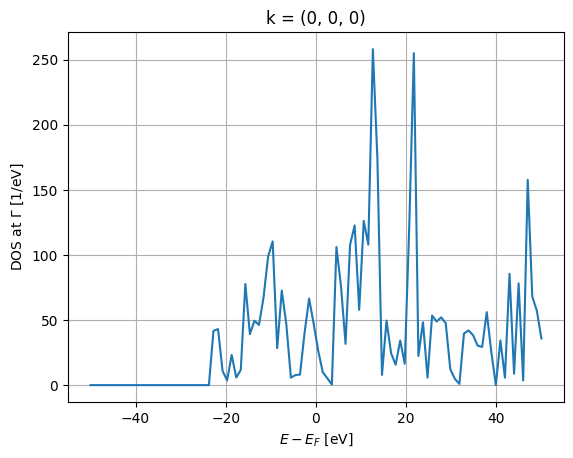

In [94]:
es = H.eigenstate(k=(0, 0, 0))
E = np.linspace(-5, 5, 50)
print(es.DOS(E))
plt.grid()
plt.plot(E, es.DOS(E))
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")

### siesta计算的布里渊区上的平均态密度

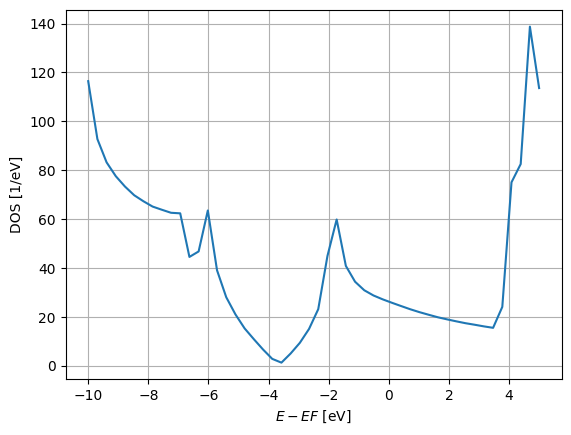

In [90]:
plt.figure()
# es = H.eigenstate()
bz = MonkhorstPack(H, [5,5,1])
bz_average = (bz.apply.average)
E = np.linspace(-10,5,50)
plt.plot(E, bz_average.eigenstate(wrap=lambda es: es.DOS(E)))
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

### siesta计算的PDOS

In [233]:
es = H_empty.eigenstate(k=(0, 0, 0))
E = np.linspace(-5, -2, 50)
# E = np.linspace(-1, -0.5, 50)
dE = E[1] - E[0]
PDOS = es.PDOS(E)  #PDOS：(1, 5850, 50)，np.array类型
# PDOS = es.PDOS(E)
print(PDOS.shape)

(1, 10400, 50)


(13, 50)


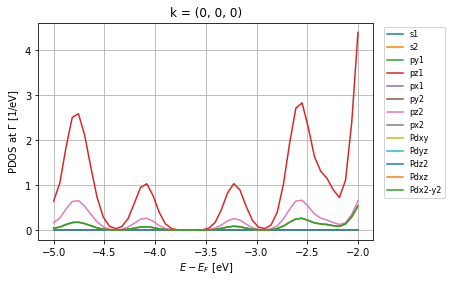

In [234]:
PDOS_data = PDOS.sum((0)) * dE  #PDOS：(1, 5850, 50)，np.array类型
pdos = np.zeros((13,50))
for i in range(13):
    for j in range(800): #800个原子
        pdos[i,:] = pdos[i,:] + PDOS_data[i+13*j,:]
# print(pdos)
print(pdos.shape)
plt.grid()
plt.plot(E, pdos[0,:], label='s1')
plt.plot(E, pdos[1,:], label='s2')
plt.plot(E, pdos[2,:], label='py1')
plt.plot(E, pdos[3,:], label='pz1')
plt.plot(E, pdos[4,:], label='px1')
plt.plot(E, pdos[5,:], label='py2')
plt.plot(E, pdos[6,:], label='pz2')
plt.plot(E, pdos[7,:], label='px2')
plt.plot(E, pdos[8,:], label='Pdxy')
plt.plot(E, pdos[9,:], label='Pdyz')
plt.plot(E, pdos[10,:], label='Pdz2')
plt.plot(E, pdos[11,:], label='Pdxz')
plt.plot(E, pdos[11,:], label='Pdx2-y2')
plt.legend(bbox_to_anchor=(1.02, 1), fontsize = 8)
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"PDOS at $\Gamma$ [1/eV]")
plt.show()

In [226]:
es = H.eigenstate()
E = np.linspace(-5, -2, 50)
dE = E[1] - E[0]
PDOS = es.PDOS(E).sum((0, 2)) * dE  # perform integration
normalize = np.linalg.norm(PDOS, np.inf)
normalize = PDOS / normalize
geom1.plot(axes="xy", atoms_style={"size": normalize})
# plt.scatter(system.xyz[:, 0], system.xyz[:, 1], 500 * PDOS);
# plt.scatter(xyz_remove[0], xyz_remove[1], c='k', marker='*'); # mark the removed atom

/fs2/software/python/3.9_anaconda_2022.05/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

/fs2/software/python/3.9_anaconda_2022.05/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning:

Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.



### siesta计算的能带

In [96]:
band = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [1/3,1/3,0], [0,0,0]],
    45,
    [r"Gamma", r"M", r"K", r"Gamma"]
)
#band.plot(Erange=[-5, -2])

[[-23.096626 -23.002388 -23.002312 ... 199.62103  222.1622   222.17583 ]
 [-23.095428 -23.007998 -23.005169 ... 200.72128  222.16455  222.18088 ]
 [-23.095705 -23.014265 -23.008116 ... 201.81711  222.07903  222.09479 ]
 ...
 [-23.09572  -23.012094 -23.011755 ... 201.51009  222.07771  222.10329 ]
 [-23.096191 -23.007433 -23.007336 ... 200.56767  222.16507  222.17114 ]
 [-23.096626 -23.002388 -23.002312 ... 199.62103  222.1622   222.17583 ]]
(45, 5850)


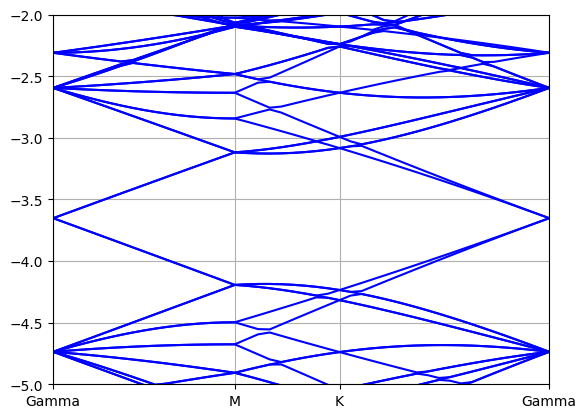

In [97]:
bs = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [1/3,1/3,0], [0,0,0]],
    45,
    [r"Gamma", r"M", r"K", r"Gamma"]
)
lk, kt, kl = bs.lineark(True)
# print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
print(bs_eig)
print(bs_eig.shape)
for i in range(bs_eig.shape[1]):
    plt.plot(lk, bs_eig[:, i], color='blue')
# plt.plot(bs.lineark(), bs_eig, color='blue')
plt.ylim(-5, -2)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()

### TGCN预测的GAMMA点处的态密度

Text(0, 0.5, 'DOS at $\\Gamma$ [1/eV]')

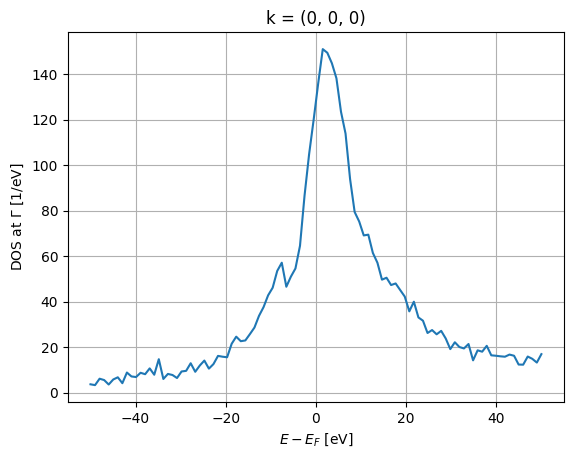

In [179]:
es = H_empty.eigenstate(k=(0, 0, 0))
E = np.linspace(-50, 50, 100)
# print(es.DOS(E))
plt.grid()
plt.plot(E, es.DOS(E))
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")

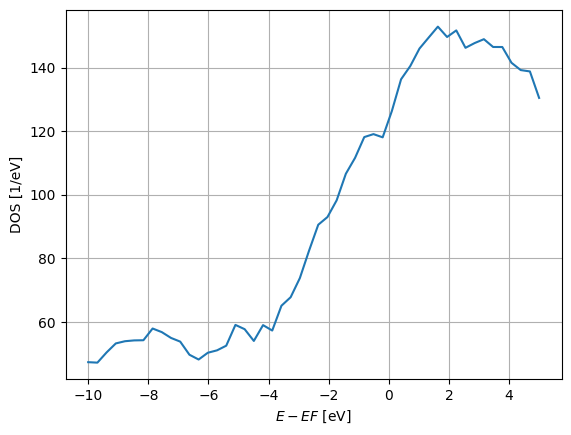

In [180]:
plt.figure()
bz = MonkhorstPack(H_empty, [5,5,1])
bz_average = (bz.apply.average)
E = np.linspace(-10,5,50)
plt.plot(E, bz_average.eigenstate(wrap=lambda es: es.DOS(E)))
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

### TGCN预测的GAMMA点处的态密度

[240.30534506+6.18387538e-02j 240.30534506-6.18387538e-02j
 241.54874834+1.05637794e-01j ...  13.18605397-1.17571645e-05j
  13.18618358+9.42972577e-06j  13.18618358-9.42972577e-06j]
[1.46022552e+01 2.37969367e+01 4.18324696e+01 5.68993404e+01
 5.87136882e+01 4.78728954e+01 3.15745593e+01 1.64888047e+01
 6.50591200e+00 1.90685859e+00 7.40816280e-01 1.84079433e+00
 5.98562380e+00 1.37465559e+01 2.17186404e+01 2.35879522e+01
 1.76099042e+01 9.03717330e+00 3.18799099e+00 7.73055153e-01
 1.28862652e-01 1.48726555e-02 3.03036591e-03 2.22618523e-02
 1.81394627e-01 1.01886014e+00 3.93385632e+00 1.04407249e+01
 1.90480722e+01 2.38879910e+01 2.05928728e+01 1.22033769e+01
 4.97820261e+00 1.46726083e+00 7.96480708e-01 2.65094810e+00
 9.26397757e+00 2.38071304e+01 4.49931308e+01 6.29588650e+01
 6.56341179e+01 5.27819922e+01 3.76874115e+01 3.02124404e+01
 2.65744294e+01 2.07052308e+01 1.65812715e+01 2.52972074e+01
 5.46714126e+01 1.00087291e+02]


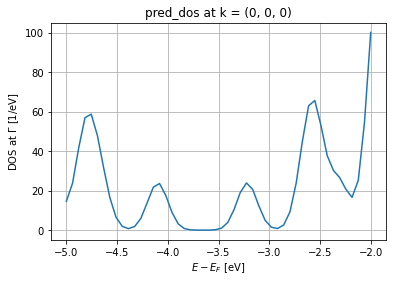

In [231]:
from sisl.physics.electron import *

# 假设 H_empty 已经被正确定义
# 定义能量范围
E = np.linspace(-5, -2, 50)

# 计算特定 k 点的本征值
eig = H_empty.eig(k=(0, 0, 0))
# eig = H_empty.eig(k=(0.33333333, 0.33333333, 0))
print(eig)

# 计算并打印态密度
dos = DOS(E, eig.real)
print(dos)

# 绘制态密度图
plt.plot(E, dos)
plt.grid()
plt.title(r"pred_dos at k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS at $\Gamma$ [1/eV]")
plt.show()

### TGCN预测的布里渊区上的平均态密度

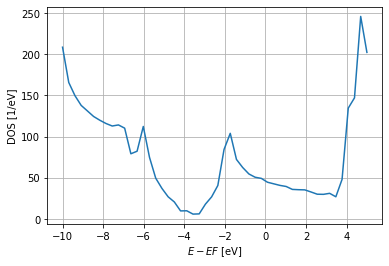

In [232]:
plt.figure()
bz = MonkhorstPack(H_empty, [5,5,1])
E = np.linspace(-10,5,50)
eig = bz.apply.average.eigh()
dos = DOS(E, eig.real)
plt.plot(E, dos)
plt.xlabel("$E - EF$ [eV]")
plt.ylabel("DOS [1/eV]")
plt.grid()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

### TGCN预测的能带

[[-6815.57624752 -6732.90258599 -6694.4964632  ...  1425.1427545
   1483.71208638  1536.1629688 ]
 [-6815.50494001 -6733.04608613 -6703.9727422  ...  1425.1830232
   1483.55002647  1535.99403234]
 [-6815.34315235 -6735.19202134 -6720.81097876 ...  1425.39572661
   1483.06556036  1535.48794374]
 ...
 [-6822.28638377 -6734.30395736 -6703.46221449 ...  1425.10801314
   1483.5011753   1535.94982649]
 [-6817.39567657 -6732.53023591 -6696.77270284 ...  1425.13183762
   1483.65929004  1536.10965879]
 [-6815.57624752 -6732.90258599 -6694.4964632  ...  1425.1427545
   1483.71208638  1536.1629688 ]]
(45, 5850)


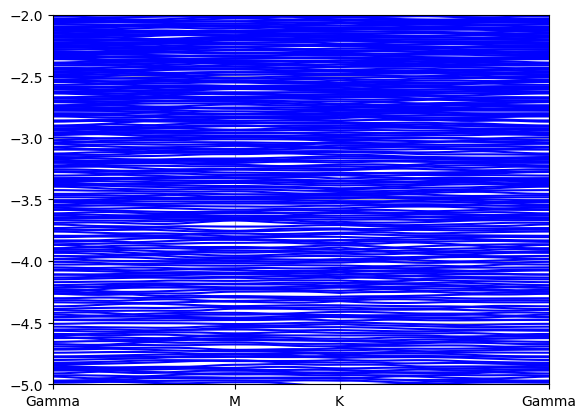

In [181]:
bs = BandStructure(
    H_empty,
    [[0,0,0], [0.5,0,0], [1/3,1/3,0], [0,0,0]],
    45,
    [r"Gamma", r"M", r"K", r"Gamma"]
)
lk, kt, kl = bs.lineark(True)
# print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
print(bs_eig)
print(bs_eig.shape)
for i in range(bs_eig.shape[1]):
    plt.plot(lk, bs_eig[:, i], color='blue')
# plt.plot(bs.lineark(), bs_eig, color='blue')
plt.ylim(-5, -2)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()

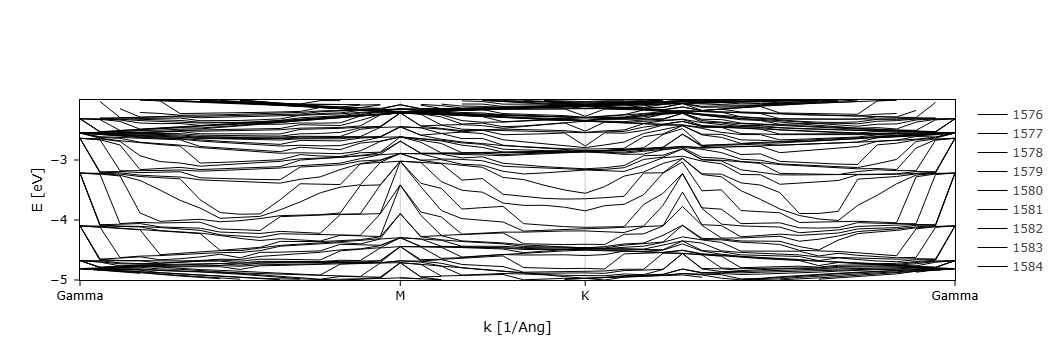

In [225]:
band = BandStructure(
    H_empty,
    [[0,0,0], [0.5,0,0], [1/3,1/3,0], [0,0,0]],
    45,
    [r"Gamma", r"M", r"K", r"Gamma"]
)
band.plot(Erange=[-5, -2])

# 假设 `band` 是 sisl.viz.BandsPlot 的一个实例
# fig = band.plot(Erange=[-2.84, -2.24], gap=True)

# 保存到本地文件，可以指定不同的格式，如png, pdf, svg等
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/band_structure.png', dpi=300)  # 保存为PNG文件，指定分辨率为300 DPI
# plt.show()
# band.plot(bands_range=[600,650])

In [71]:
fermi_level = pred_fermi_level #-3.82373，这里的费米能级可以计算出来
k_data = ["15 0 0 0 0.5 0 0 Γ M", "15 0.5 0 0 0.33333333 0.33333333 0 M K", "15 0.33333333 0.33333333 0 0 0 0 K Γ"]

print("calculate bands")
num_ks = [k_data2num_ks(k) for k in k_data] #[15,15,15]
kpaths = [k_data2kpath(k) for k in k_data] #[[0 0 0 0.5 0 0],[0.5 0 0 0.33333333 0.33333333 0],[0.33333333 0.33333333 0 0 0 0]]

egvals = np.zeros((norbits, sum(num_ks)+1)) #(2196,46)，构建了k点下存放特征值的零矩阵

begin_time = time()

k_points = np.empty((1,3))
for i in range(len(kpaths)): #0-2
    kpath = kpaths[i]
    pnkpts = num_ks[i]
    kxs = np.linspace(kpath[0], kpath[3], pnkpts, endpoint=False) #创建了一个在闭区间 [start, end] 上均匀分布的等差数列，包含了 pnkpts 个元素。
    kys = np.linspace(kpath[1], kpath[4], pnkpts, endpoint=False)
    kzs = np.linspace(kpath[2], kpath[5], pnkpts, endpoint=False)
    matrix = np.column_stack((kxs, kys, kzs))
    k_points = np.vstack((k_points, matrix))
k_points = np.delete(k_points, 0, axis=0)
k_points = np.vstack((k_points, np.array(kpaths[2][3:])))
# print(k_points)
print(k_points.shape) #46*3
idx_k = 0
for i in range(len(k_points)): #同时迭代处理这三个列表中对应位置的元素。
    kx, ky, kz = k_points[i,:]
    H_k = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
    S_k = np.zeros((norbits, norbits), dtype=default_dtype)
    for R in H_R.keys(): #下面两个表达式的意思可能是在k（动量）空间中，通过加权计算不同晶格向量位置上的哈密顿量矩阵，并将结果累加到 H_k 中。
        H_k += H_R[R] * np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R)) #np.dot两个向量的点积运算。点积（内积）操作将这两个向量对应位置的元素相乘，然后将所有相乘结果相加得到一个标量值。这个结果表示了两个向量之间的投影关系和相似性。
        S_k += S_R[R] * np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R)) #复数值为np.exp(1j*2*np.pi*np.dot([kx, ky, kz], R))。
    #---------------------------------------------
    # BS: only eigenvalues are needed in this part,
    # the upper matrix is used
    #
    # egval, egvec = linalg.eig(H_k, S_k)
    egval = linalg.eigvalsh(H_k, S_k, lower=False) #使用了SciPy中linalg.eigvalsh()函数来计算一个Hermitean（厄米特）矩阵H_k的特征值。同时，它指定了矩阵S_k作为正交矩阵，用于进行特征值计算。返回一个数组egval，其中包含了H_k的特征值。参数lower=False表示计算所有的特征值，且这些特征值按照升序排列。
    egvals[:, idx_k] = egval #这里只计算了一个路径下一个k点的特征值，每一列是某一个k点下的所有特征值2196个。所以每一行就是一条能带！2196*46

    print("Time for solving No.{} eigenvalues at k = {} : {} s".format(idx_k+1, [kx, ky, kz], time() - begin_time))
    idx_k += 1 #计算其它路径下k点的特征值

spin=int(spinful)+1
siesta_rlat = np.array(rlat * Bohr2Ang) #(3,3)倒格矢
ymin = egvals.min() #-14.065387633674039
ymax = egvals.max() #17.63961205616035
# print(ymin, ymax)

kpoint = 0.000000
k_list = [0.000000]
for i in range(len(k_points)-1):  # 同时迭代处理这三个列表中对应位置的元素。
    kvec0 = k_points[i, :]
    kvec1 = k_points[i + 1, :]
    kpoint = np.linalg.norm(kvec0 @ siesta_rlat - kvec1 @ siesta_rlat) + kpoint
    k_list.append(np.around(kpoint, decimals=6))
# print("kpoint = ", k_list)
assert len(k_list) == len(k_points) #求出k点
print(k_list)

calculate bands
(46, 3)
Time for solving No.1 eigenvalues at k = [0.0, 0.0, 0.0] : 25.01978611946106 s
Time for solving No.2 eigenvalues at k = [0.03333333333333333, 0.0, 0.0] : 49.8154091835022 s
Time for solving No.3 eigenvalues at k = [0.06666666666666667, 0.0, 0.0] : 74.6604516506195 s
Time for solving No.4 eigenvalues at k = [0.1, 0.0, 0.0] : 99.31642985343933 s
Time for solving No.5 eigenvalues at k = [0.13333333333333333, 0.0, 0.0] : 124.35705947875977 s
Time for solving No.6 eigenvalues at k = [0.16666666666666666, 0.0, 0.0] : 147.74082159996033 s
Time for solving No.7 eigenvalues at k = [0.2, 0.0, 0.0] : 172.7063443660736 s
Time for solving No.8 eigenvalues at k = [0.23333333333333334, 0.0, 0.0] : 195.91478824615479 s
Time for solving No.9 eigenvalues at k = [0.26666666666666666, 0.0, 0.0] : 219.5349690914154 s
Time for solving No.10 eigenvalues at k = [0.3, 0.0, 0.0] : 244.4474425315857 s
Time for solving No.11 eigenvalues at k = [0.3333333333333333, 0.0, 0.0] : 268.915189743

In [88]:
egvals

array([[-23.04980222, -23.04969845, -23.04938712, ..., -23.04924893,
        -23.04966391, -23.04980222],
       [-22.95514661, -22.96125773, -22.96732943, ..., -22.96718613,
        -22.96122318, -22.95514661],
       [-22.95505275, -22.9580495 , -22.96092515, ..., -22.96717155,
        -22.96120789, -22.95505275],
       ...,
       [242.27272132, 242.55148204, 243.79399054, ..., 244.40790562,
        242.99842095, 242.27272132],
       [268.65463866, 268.61061111, 268.47876943, ..., 268.421692  ,
        268.59630269, 268.65463866],
       [273.10964631, 273.06384881, 272.92666707, ..., 272.86818637,
        273.04919908, 273.10964631]])

In [94]:
H_empty.eigh(k=k_points[1])

array([-579.01442673, -157.53802855,  -48.03948466, ...,  301.70906272,
        335.02317376,  639.18766965])

(5850, 46)
46


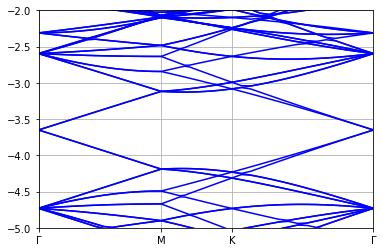

In [77]:
print(egvals.shape)
print(len(k_list))
for i in range(len(egvals)): 
    plt.plot(k_list, egvals[i, :], color='blue')
# plt.plot(bs.lineark(), bs_eig, color='blue')
plt.ylim(-5, -2)
plt.xlim(k_list[0], k_list[-1])
plt.xticks([k_list[0], k_list[15], k_list[30], k_list[-1]], ['Γ', 'M', 'K', 'Γ']) 
plt.grid()
plt.show()

# for i in range(len(egvals)):  # 同时迭代处理这三个列表中对应位置的元素。
#     E_K = np.column_stack((np.array(k_list), egvals[i, :])) #写入每个k点的特征值，已校归零到费米能级
#     f.write(std_out_EKarray(E_K) + "\n\n")

### 哈密顿矩阵误差对比图

In [235]:
tmp = H.Hk(k=(0,0,0),format='dense') - H_empty.Hk(k=(0,0,0), format='dense')
print(type(tmp))

<class 'numpy.ndarray'>


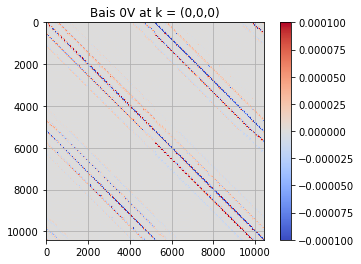

In [239]:
#哈密顿矩阵误差对比图
min_value = np.min(tmp)
max_value = np.max(tmp)
cmap = plt.cm.get_cmap('coolwarm')
# plt.imshow(tmp, cmap=cmap, vmin=min_value, vmax=max_value)
plt.imshow(tmp, cmap=cmap, vmin=-0.0001, vmax=0.0001)
# plt.imshow(Sk, cmap=cmap)
plt.colorbar()
plt.grid()
plt.title("Bais 0V at k = (0,0,0)")
plt.show()

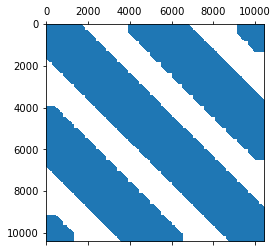

In [237]:
plt.spy(H_empty.Hk(k=(0,0,0)))

In [ ]:
# 创建一个 tshsSileSiesta 对象来写入文件
# 您需要指定要写入的文件名和模式
tshs_file = siesta.tshsSileSiesta("/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/test.TSHS", mode='w')

# 使用 write_hamiltonian 方法将数据写入文件
tshs_file.write_hamiltonian(tmp)

### 验证单步自洽计算出的重叠矩阵和电子结构自洽收敛的重叠矩阵一样。

In [ ]:
S_pred = S_R[(0, 0, 0)]
print(np.max(S_pred))
print(np.min(S_pred))
plt.spy(S_pred)

In [ ]:
tmp = np.zeros((5850,5850))
for i in range(5850):
    k = 0
    for j in range(40950,46800):
        tmp[i,k] = H.H[i, j]
        k = k+1
plt.spy(tmp)

In [ ]:
# 现在你可以传递这些numpy数组到linalg.eigvalsh
egval = linalg.eigvalsh(H_matrix, S_matrix)
print(egval)
print(egval.shape)